# Análisis de Series Temporales: Impacto de Madrid Central en la Calidad del Aire

## Descripción del Proyecto

Este proyecto analiza el impacto de la implementación de Madrid Central en la calidad del aire, específicamente en la concentración de dióxido de nitrógeno (NO2). Utilizando técnicas de análisis de series temporales con pandas, se examina cómo varió la presencia de NO2 antes y después de la entrada en vigor de esta medida de restricción de tráfico el 30 de noviembre de 2018. 

<img src="madrid_central.png" style="width: 600px">


Este análisis utiliza los [datos del "Sistema Integral de la Calidad del Aire del Ayuntamiento de Madrid"](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) que publica su portal de datos abiertos.

**Objetivo:** Analizar cómo varió la presencia de dióxido de nitrógeno (NO2) en las mediciones realizadas por una estación de calidad del aire dentro de Madrid Central, en torno a la fecha en que se activó por primera vez la restricción el 30 de noviembre de 2018. 

**Pregunta de investigación:** ¿Disminuyó la concentración de NO2 en el aire tras la aplicación de Madrid Central?



## Inicialización

La siguiente celda importa `geopandas` y otras librerías necesarias para la visualización geográfica. En caso de que no estén instaladas, se realizará la instalación automática. **Nota:** Se recomienda realizar la instalación de geopandas y folium usando la terminal de conda para mayor estabilidad. 

In [78]:
import geopandas as gpd
from shapely.geometry import Point

In [79]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
try: 
    import geopandas as gpd
    from shapely.geometry import Point
except:
    !{sys.executable} -m pip install geopandas 
    !{sys.executable} -m pip install folium
    !{sys.executable} -m pip install mapclassify
    import geopandas as gpd
    from shapely.geometry import Point

**Nota:** En caso de que la instalación presente problemas, esto no afecta al desarrollo del análisis principal, ya que estas librerías se utilizan únicamente para la visualización del mapa de estaciones.

In [80]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)
from pathlib import Path

## Metodología

El análisis se estructura en los siguientes pasos:

### Carga de los datos

Madrid Central entró en vigor el **30 de noviembre de 2018**. Desafortunadamente, los datos vienen en este caso en CSV por mes. **Lee todos los CSVs de 2018, 2019 y 2020 y juntalos en un único dataframe.**


In [81]:
# Crear un DataFrame vacío y una lista para almacenar los DataFrames
air_q = pd.DataFrame()
dataframes = []

# Leer cada archivo CSV y agregar el DataFrame a la lista
for csv_file in Path('.').glob('Anio*/*.csv'):
    
    df = pd.read_csv(csv_file, sep=';', encoding='latin1')
    dataframes.append(df)

# Cantidad de archivos cargados
print(len(dataframes), "archivos cargados")

# Concatenar todos los DataFrames en uno solo
air_q = pd.concat(dataframes, ignore_index=True)

# Mostrar el DataFrame resultante
air_q


33 archivos cargados


,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2018,4,1,2.00,V,...,2.00,V,2.00,V,3.00,V,4.00,V,3.00,V
1,28,79,4,1,28079004_1_38,2018,4,2,2.00,V,...,2.00,V,2.00,V,2.00,V,2.00,V,2.00,V
2,28,79,4,1,28079004_1_38,2018,4,3,2.00,V,...,2.00,V,2.00,V,2.00,V,2.00,V,2.00,V
3,28,79,4,1,28079004_1_38,2018,4,4,2.00,V,...,2.00,V,2.00,V,2.00,V,2.00,V,2.00,V
4,28,79,4,1,28079004_1_38,2018,4,5,2.00,V,...,2.00,V,2.00,V,4.00,V,5.00,V,4.00,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151265,28,79,60,14,28079060_14_6,2020,6,26,80.51,V,...,91.14,V,87.98,V,90.96,V,85.05,V,74.69,V
151266,28,79,60,14,28079060_14_6,2020,6,27,73.75,V,...,80.66,V,80.82,V,76.82,V,72.74,V,64.10,V
151267,28,79,60,14,28079060_14_6,2020,6,28,48.81,V,...,87.62,V,83.21,V,75.26,V,50.27,V,51.70,V
151268,28,79,60,14,28079060_14_6,2020,6,29,60.51,V,...,114.00,V,102.40,V,91.50,V,73.67,V,64.14,V


El resultado de la carga de datos será un dataframe con el siguiente aspecto:


<img src="dataset.png" style="width: 800px">

### Filtrado

El siguiente plot muestra sobre un mapa la zona a la que aplica Madrid Central, junto con las estaciones de medición de calidad del aire:

In [82]:
gdf = gpd.read_file("Madrid_Central/Madrid_Central.shp")
gdf = gdf.to_crs(epsg=3857)
est = pd.read_csv('estaciones.csv', delimiter=';', encoding='latin-1', decimal='.')
gdf_est = gpd.GeoDataFrame(
    est, 
    geometry=[Point(x, y) for x, y in zip(est.LONGITUD, est.LATITUD)]
)

gdf = gdf.to_crs('epsg:4326')
ax = gdf.explore()
gdf_est.explore(m = ax, marker_type = 'marker')

La única estación que está dentro de Madrid Central es la de "Pza. del Carmen".
* **Filtra el dataframe `air_q` para quedarte con la información relativa solo a esa estación**. 
* Busca manualmente qué puedes usar para filtrar en `estacion.csv`, ayudándote de la documentación en el PDF `Interprete_ficheros_ calidad_ del_ aire_global.pdf`. 
* Elimina las columnas `PROVINCIA`, `MUNICIPIO`, `ESTACION`y `PUNTO_MUESTREO`, que ya no las vamos a necesitar.

In [83]:
# Punto 2: Busca manualmente qué puedes usar para filtrar en `estacion.csv`,

# Leer el archivo CSV con las estaciones para obtener el codigo corto de la estacion "Pza. del Carmen"
df_estaciones = pd.read_csv("estaciones.csv", sep=";", encoding="latin1")

# Filtrar el DataFrame para obtener la fila correspondiente a la estacion "Pza. del Carmen"
df_estaciones.loc[
    df_estaciones.ESTACION == "Pza. del Carmen"
]

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,...,HC,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD
8,28079035,35,Pza. del Carmen,Plaza del Carmen esq. Tres Cruces.,"3°42'11.40""O","40°25'9.15""N",660,UF,Urbana fondo,X,...,NaN,145800,PLAZA,DEL,CARMEN,01/11/1999,"440346,3619","4474524,357",-3.703166,40.419209


In [84]:
# Punto 1. Filtra el dataframe `air_q` para quedarte con la información relativa solo a esa estación "Pza. del Carmen"

# Filtrar el DataFrame `air_q` para quedarse solo con las filas correspondientes a la estacion "Pza. del Carmen"
air_q = air_q.loc[
            air_q['ESTACION'] == 35
]

# Mostrar el DataFrame resultante
air_q

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
1850,28,79,35,1,28079035_1_38,2018,4,1,7.00,V,...,7.00,V,9.00,V,7.00,V,7.00,V,8.00,V
1851,28,79,35,1,28079035_1_38,2018,4,2,9.00,V,...,7.00,V,7.00,V,7.00,V,1.00,V,1.00,V
1852,28,79,35,1,28079035_1_38,2018,4,3,3.00,V,...,4.00,V,4.00,V,6.00,V,7.00,V,7.00,V
1853,28,79,35,1,28079035_1_38,2018,4,4,6.00,V,...,5.00,V,6.00,V,6.00,V,7.00,V,7.00,V
1854,28,79,35,1,28079035_1_38,2018,4,5,7.00,V,...,7.00,V,7.00,V,7.00,V,9.00,V,8.00,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148745,28,79,35,14,28079035_14_6,2020,6,26,72.41,V,...,89.60,V,84.99,V,86.69,V,83.57,V,79.09,V
148746,28,79,35,14,28079035_14_6,2020,6,27,69.22,V,...,74.24,V,70.86,V,67.46,V,59.63,V,56.24,V
148747,28,79,35,14,28079035_14_6,2020,6,28,49.72,V,...,90.01,V,86.00,V,75.61,V,45.98,V,42.48,V
148748,28,79,35,14,28079035_14_6,2020,6,29,51.87,V,...,109.00,V,103.60,V,86.82,V,63.62,V,60.43,V


In [85]:
# Punto 3: Elimina las columnas `PROVINCIA`, `MUNICIPIO`, `ESTACION`y `PUNTO_MUESTREO`, que ya no las vamos a necesitar.

# Array con las columnas a borrar
columnas_a_borrar = ["PROVINCIA", "MUNICIPIO", "ESTACION" , "PUNTO_MUESTREO"]

# Eliminación de las columnas indicadas del DataFrame
air_q.drop(columnas_a_borrar, axis=1, inplace=True)

# Mostrar el DataFrame resultante
air_q

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_71074/220786580.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_q.drop(columnas_a_borrar, axis=1, inplace=True)


,MAGNITUD,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
1850,1,2018,4,1,7.00,V,6.00,V,5.00,V,...,7.00,V,9.00,V,7.00,V,7.00,V,8.00,V
1851,1,2018,4,2,9.00,V,7.00,V,5.00,V,...,7.00,V,7.00,V,7.00,V,1.00,V,1.00,V
1852,1,2018,4,3,3.00,V,4.00,V,5.00,V,...,4.00,V,4.00,V,6.00,V,7.00,V,7.00,V
1853,1,2018,4,4,6.00,V,7.00,V,7.00,V,...,5.00,V,6.00,V,6.00,V,7.00,V,7.00,V
1854,1,2018,4,5,7.00,V,5.00,V,5.00,V,...,7.00,V,7.00,V,7.00,V,9.00,V,8.00,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148745,14,2020,6,26,72.41,V,62.75,V,56.86,V,...,89.60,V,84.99,V,86.69,V,83.57,V,79.09,V
148746,14,2020,6,27,69.22,V,62.49,V,63.91,V,...,74.24,V,70.86,V,67.46,V,59.63,V,56.24,V
148747,14,2020,6,28,49.72,V,38.01,V,31.06,V,...,90.01,V,86.00,V,75.61,V,45.98,V,42.48,V
148748,14,2020,6,29,51.87,V,38.80,V,51.93,V,...,109.00,V,103.60,V,86.82,V,63.62,V,60.43,V


### Cambio de estructura de los valores de medición

Si atendemos a la documentación en  `Interprete_ficheros_calidad_del_aire_global.pdf`, observamos que las mediciones vienen en un formato con el que no nos va a resultar muy sencillo trabajar: 
cada fila contiene 24 mediciones (una por hora) de cada uno de los compuestos que se miden en el aire (el compuesto que se mide viene indicado en la columna `MAGNITUD`). 

Para facilitar el trabajo, vamos a hacer que cada fila contenga solo una hora (y la medición de esa hora). Crear un nuevo dataframe llamado `stacked_air_q`, donde por cada fila de `air_q`, tendremos 24 filas en `stacked_air_q` (puedes investigar acerca de la función `pd.melt()`, aunque no es la única forma de hacerlo).

In [86]:
#Creo una variable con los nombres de las columnas coon la medición H1 ... H24
horas = [f'H{str(i).zfill(2)}' for i in range(1, 25)]

# Aplicar la función melt para apilar las columnas de las horas
stacked_air_q = air_q.melt(
    id_vars=["MAGNITUD", "ANO", "MES", "DIA"],
    value_vars=horas,
    var_name="HORA",
    value_name="VALOR",
    ignore_index=False
)

# Mostrar el dataframe
stacked_air_q

,MAGNITUD,ANO,MES,DIA,HORA,VALOR
1850,1,2018,4,1,H01,7.00
1851,1,2018,4,2,H01,9.00
1852,1,2018,4,3,H01,3.00
1853,1,2018,4,4,H01,6.00
1854,1,2018,4,5,H01,7.00
...,...,...,...,...,...,...
148745,14,2020,6,26,H24,79.09
148746,14,2020,6,27,H24,56.24
148747,14,2020,6,28,H24,42.48
148748,14,2020,6,29,H24,60.43


Las nuevas filas de `stacked_air_q` preservan el índice de la fila a partir del cual se generaron. Combina los dataframes `stacked_air_q` y `air_q` para conseguir que el dataframe `air_q` tenga una medicción por hora y fila.

In [87]:
#Fusiono los dos dataframe con merge
air_q = pd.merge(
    stacked_air_q,
    air_q,
    how="outer",
    left_index=True,
    right_index=True,
    suffixes=('', '_right')
)

# Mostrar el dataframe
air_q

,MAGNITUD,ANO,MES,DIA,HORA,VALOR,MAGNITUD_right,ANO_right,MES_right,DIA_right,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
1850,1,2018,4,1,H01,7.00,1,2018,4,1,...,7.0,V,9.0,V,7.00,V,7.0,V,8.00,V
1850,1,2018,4,1,H02,6.00,1,2018,4,1,...,7.0,V,9.0,V,7.00,V,7.0,V,8.00,V
1850,1,2018,4,1,H03,5.00,1,2018,4,1,...,7.0,V,9.0,V,7.00,V,7.0,V,8.00,V
1850,1,2018,4,1,H04,5.00,1,2018,4,1,...,7.0,V,9.0,V,7.00,V,7.0,V,8.00,V
1850,1,2018,4,1,H05,4.00,1,2018,4,1,...,7.0,V,9.0,V,7.00,V,7.0,V,8.00,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148749,14,2020,6,30,H20,108.90,14,2020,6,30,...,108.9,V,108.2,V,94.51,V,94.3,V,84.13,V
148749,14,2020,6,30,H21,108.20,14,2020,6,30,...,108.9,V,108.2,V,94.51,V,94.3,V,84.13,V
148749,14,2020,6,30,H22,94.51,14,2020,6,30,...,108.9,V,108.2,V,94.51,V,94.3,V,84.13,V
148749,14,2020,6,30,H23,94.30,14,2020,6,30,...,108.9,V,108.2,V,94.51,V,94.3,V,84.13,V


Las columnas que comienzan con "H*" y "V*", que ya no son necesarias. por lo que puedes eliminarlas.

In [88]:
# Defino el dataframe solo con las columnas que serán necesarias
air_q = air_q[["MAGNITUD", "ANO", "MES", "DIA", "HORA", "VALOR"]]

# Mostrar el dataframe
air_q

,MAGNITUD,ANO,MES,DIA,HORA,VALOR
1850,1,2018,4,1,H01,7.00
1850,1,2018,4,1,H02,6.00
1850,1,2018,4,1,H03,5.00
1850,1,2018,4,1,H04,5.00
1850,1,2018,4,1,H05,4.00
...,...,...,...,...,...,...
148749,14,2020,6,30,H20,108.90
148749,14,2020,6,30,H21,108.20
148749,14,2020,6,30,H22,94.51
148749,14,2020,6,30,H23,94.30


Una vez completado lo anterior, tenemos un dataframe con esta pinta. Comprueba que tu dataframe resultante tenga una columna con nombre `HORA` y  otra columna con nombre `VALOR`. Renombra si es necesario.

<img src="dataset_transform.png" style="width: 300px">


In [89]:
#Nota:  A pesar de seguir los pasos de la consigna, creo que era innecesaria la combinación entre air_q y stacked_air_q.
#       Por lo menos en mi caso en el melt conservé ["MAGNITUD", "ANO", "MES", "DIA"], quizás la fusión indicada en 
#       la consigna estaba pensada para alguna forma alternativa de hacer el melt o utilizar otra función equivalente a melt.

### Indexar por tiempo

Ahora, crea una nueva columna a partir de `"ANO", "MES", "DIA", "HORA"` y obten una nueva columna con la fecha. Te en cuenta que la hora `24` ha de pasar a ser  `00`.



<div style="width: 400px">
    </br>
    
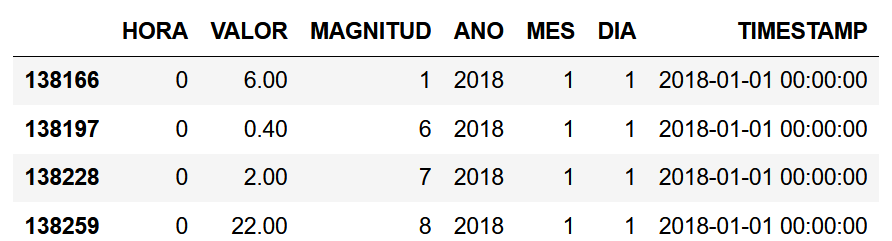
</br>
    
</div>

In [90]:
# Tratamiento de la columna HORA
# Labda para convertir la hora 24 a 0 y quitar la H
air_q["HORA"] =  air_q["HORA"].apply(lambda x: 0 if x == "H24" else int(x.replace("H",""))) 

# Mostrar el dataframe
air_q

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_71074/1646637302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_q["HORA"] =  air_q["HORA"].apply(lambda x: 0 if x == "H24" else int(x.replace("H","")))


,MAGNITUD,ANO,MES,DIA,HORA,VALOR
1850,1,2018,4,1,1,7.00
1850,1,2018,4,1,2,6.00
1850,1,2018,4,1,3,5.00
1850,1,2018,4,1,4,5.00
1850,1,2018,4,1,5,4.00
...,...,...,...,...,...,...
148749,14,2020,6,30,20,108.90
148749,14,2020,6,30,21,108.20
148749,14,2020,6,30,22,94.51
148749,14,2020,6,30,23,94.30


In [91]:
# Crear la columna TIMESTAMP
air_q["TIMESTAMP"] = pd.to_datetime(
    air_q.ANO.astype(str) + "-" + 
    air_q.MES.astype(str).str.zfill(2) + "-" + 
    air_q.DIA.astype(str).str.zfill(2) + " " +
    air_q.HORA.astype(str).str.zfill(2) + ":00:00" ,
    format="%Y-%m-%d %H:%M:%S",  
)

#Reordenar las columnas 
air_q = air_q[["HORA","VALOR","MAGNITUD","ANO","MES","DIA","TIMESTAMP"]]

# Mostrar el dataframe
air_q

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_71074/2517712457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_q["TIMESTAMP"] = pd.to_datetime(


,HORA,VALOR,MAGNITUD,ANO,MES,DIA,TIMESTAMP
1850,1,7.00,1,2018,4,1,2018-04-01 01:00:00
1850,2,6.00,1,2018,4,1,2018-04-01 02:00:00
1850,3,5.00,1,2018,4,1,2018-04-01 03:00:00
1850,4,5.00,1,2018,4,1,2018-04-01 04:00:00
1850,5,4.00,1,2018,4,1,2018-04-01 05:00:00
...,...,...,...,...,...,...,...
148749,20,108.90,14,2020,6,30,2020-06-30 20:00:00
148749,21,108.20,14,2020,6,30,2020-06-30 21:00:00
148749,22,94.51,14,2020,6,30,2020-06-30 22:00:00
148749,23,94.30,14,2020,6,30,2020-06-30 23:00:00


### Magnitudes medidas
Pivota ahora la tabla en torno a `MAGNITUD`, para que cada magnitud sea una columna. Esta tabla pivotada tendrá como índice "TIMESTAMP", como valores "VALOR" y como columnas "MAGNITUD". 

En este punto tendremos lo siguiente:
<img src="magnitude_transform.png" style="width: 300px">


In [92]:
#Pivotar la tabla
air_q = air_q.pivot_table(
    index = "TIMESTAMP",
    columns = "MAGNITUD",
    values = "VALOR",
)

# Mostrar el dataframe
air_q

MAGNITUD,1,6,7,8,12,14
TIMESTAMP,,,,,,
2018-01-01 00:00:00,6.0,0.4,2.0,22.0,25.0,32.60
2018-01-01 01:00:00,5.0,0.2,2.0,19.0,21.0,41.97
2018-01-01 02:00:00,5.0,0.3,3.0,29.0,34.0,30.16
2018-01-01 03:00:00,6.0,0.2,7.0,35.0,45.0,24.23
2018-01-01 04:00:00,6.0,0.2,13.0,38.0,57.0,24.16
...,...,...,...,...,...,...
2020-09-30 19:00:00,9.0,0.4,3.0,21.0,26.0,110.10
2020-09-30 20:00:00,9.0,0.5,1.0,23.0,25.0,100.60
2020-09-30 21:00:00,9.0,0.5,2.0,29.0,32.0,86.70


Ponle nombre a las magnitudes según lo que se explica en `Interprete_ficheros_ calidad_ del_ aire_global.pdf`

In [93]:
# Renombrar las columnas
air_q.rename(
    columns={
        1: "Dióxido de Azufre SO2",
        6: "Monóxido de Carbono CO",
        7: "Monóxido de Nitrógeno NO",
        8: "Dióxido de Nitrógeno NO2",
        12: "Óxidos de Nitrógeno NOx",
        14: "Ozono O3",
    },
    inplace=True
)

# Mostrar el dataframe
air_q

MAGNITUD,Dióxido de Azufre SO2,Monóxido de Carbono CO,Monóxido de Nitrógeno NO,Dióxido de Nitrógeno NO2,Óxidos de Nitrógeno NOx,Ozono O3
TIMESTAMP,,,,,,
2018-01-01 00:00:00,6.0,0.4,2.0,22.0,25.0,32.60
2018-01-01 01:00:00,5.0,0.2,2.0,19.0,21.0,41.97
2018-01-01 02:00:00,5.0,0.3,3.0,29.0,34.0,30.16
2018-01-01 03:00:00,6.0,0.2,7.0,35.0,45.0,24.23
2018-01-01 04:00:00,6.0,0.2,13.0,38.0,57.0,24.16
...,...,...,...,...,...,...
2020-09-30 19:00:00,9.0,0.4,3.0,21.0,26.0,110.10
2020-09-30 20:00:00,9.0,0.5,1.0,23.0,25.0,100.60
2020-09-30 21:00:00,9.0,0.5,2.0,29.0,32.0,86.70


### Primer plot: efecto inmediato de Madrid Central

Crear un gráfico para estudiar la evolución del dióxido de nitrógeno a lo largo de las fechas que disponemos. Marcaremos con una barra roja la entrada en vigor de Madrid Central (2018-11-30). El gráfico tendrá el siguiente aspecto (plotly y matplotlib):

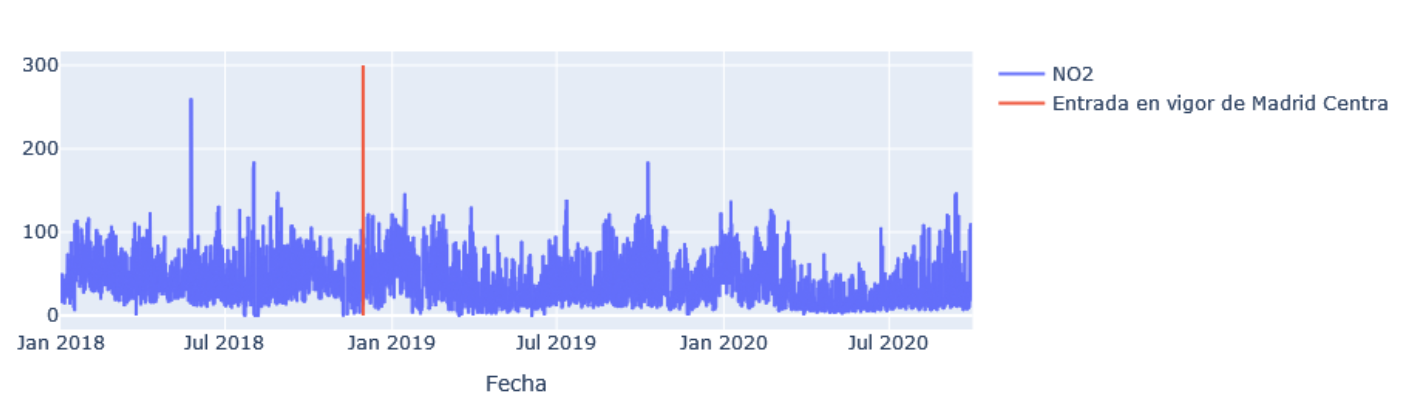


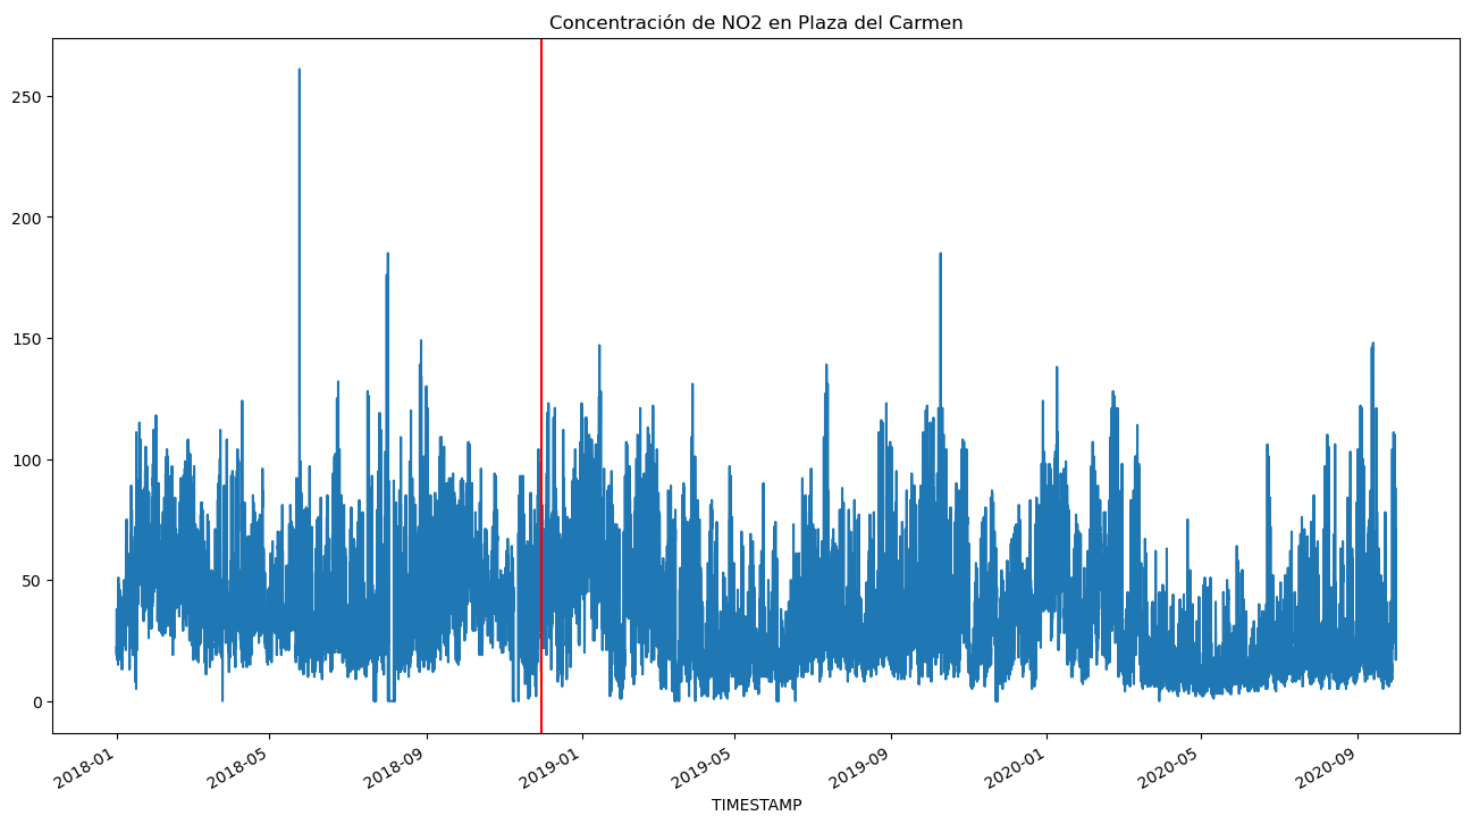

<Axes: xlabel='TIMESTAMP'>

Text(0.5, 1.0, 'Concentración de NO2 en Plaza del Carmen')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'µg/m³')

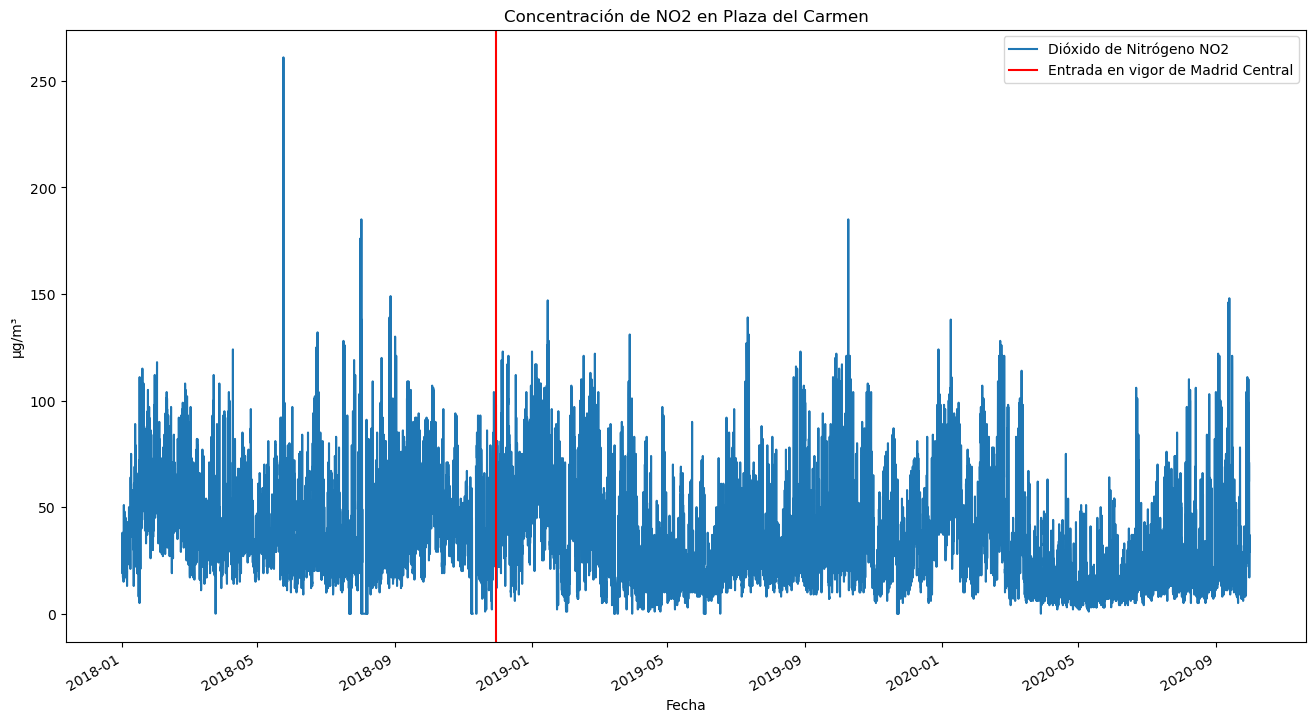

In [149]:
fig, ax = plt.subplots()
air_q["Dióxido de Nitrógeno NO2"].plot(ax=ax)
ax.axvline(
    pd.to_datetime("2018-11-30"), 
    color="red", 
    linestyle="-" , 
    label="Entrada en vigor de Madrid Central" ) 
plt.title("Concentración de NO2 en Plaza del Carmen")
plt.xlabel("Fecha")
plt.ylabel("µg/m³")
plt.legend()
plt.show()


### Segundo plot: medición de la diferencia

El gráfico anterior no nos permite analizar bien si la entrada de Madrid Central tiene un impacto real. Vamos a crear un gráfico donde se vea  la diferencia punto a punto entre 2018, 2019 y 2020. Para ello vamos a realizar una serie de acciones:

__a)__ Calcula la media diaria de Dióxido de Nitrógeno. Crea una nueva columna `media_movil` con media móvil  de un año completo para observar la tendencia del NO2.
Crea un gráfico con los datos de la media mensual junto con los datos de la media móvil a un año.

El gráfico será del estilo:


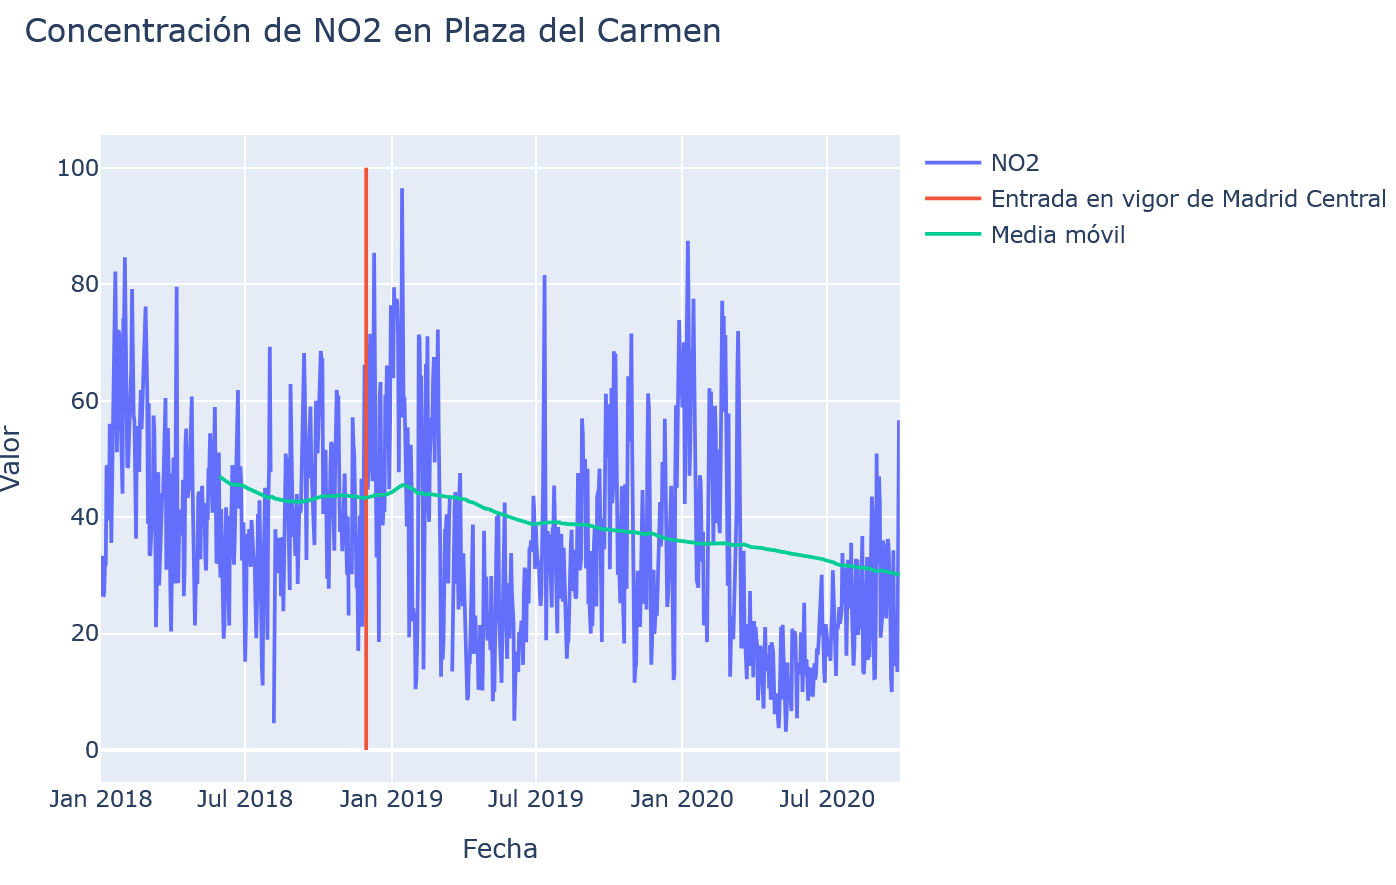

In [150]:
# Calcular la media diaria de Dióxido de Nitrógeno
media_diaria_no2 = air_q["Dióxido de Nitrógeno NO2"].resample('D').mean()

# Convertir a DataFrame
df_no2 = media_diaria_no2.to_frame(name="Dióxido de Nitrógeno NO2")

# Agregar la media móvil anual a los datos diarios
df_no2["media_movil"] = df_no2["Dióxido de Nitrógeno NO2"].rolling(window=365, min_periods=180).mean()

# Mostrar el DataFrame
df_no2

,Dióxido de Nitrógeno NO2,media_movil
TIMESTAMP,,
2018-01-01,26.541667,NaN
2018-01-02,32.083333,NaN
2018-01-03,33.375000,NaN
2018-01-04,26.333333,NaN
2018-01-05,26.958333,NaN
...,...,...
2020-09-26,18.916667,30.257534
2020-09-27,13.416667,30.147032
2020-09-28,48.333333,30.142009


In [151]:
# Calcular la media mensual
df_no2_mensual = df_no2.resample('ME').mean()

# Agregar la media móvil anual a los datos mensuales
df_no2_mensual["media_movil"] = df_no2["Dióxido de Nitrógeno NO2"].rolling(window=365, min_periods=180).mean().resample('ME').mean()
df_no2_mensual  

,Dióxido de Nitrógeno NO2,media_movil
TIMESTAMP,,
2018-01-31,51.853495,NaN
2018-02-28,58.505952,NaN
2018-03-31,40.993280,NaN
2018-04-30,42.277778,NaN
2018-05-31,41.552419,NaN
2018-06-30,37.755556,45.386687
2018-07-31,31.838710,44.214500
2018-08-31,38.090774,42.968076
2018-09-30,46.663889,42.833783


<Axes: xlabel='TIMESTAMP'>

<Axes: xlabel='TIMESTAMP'>

Text(0.5, 1.0, 'Concentración de NO2 en Plaza del Carmen')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'µg/m³')

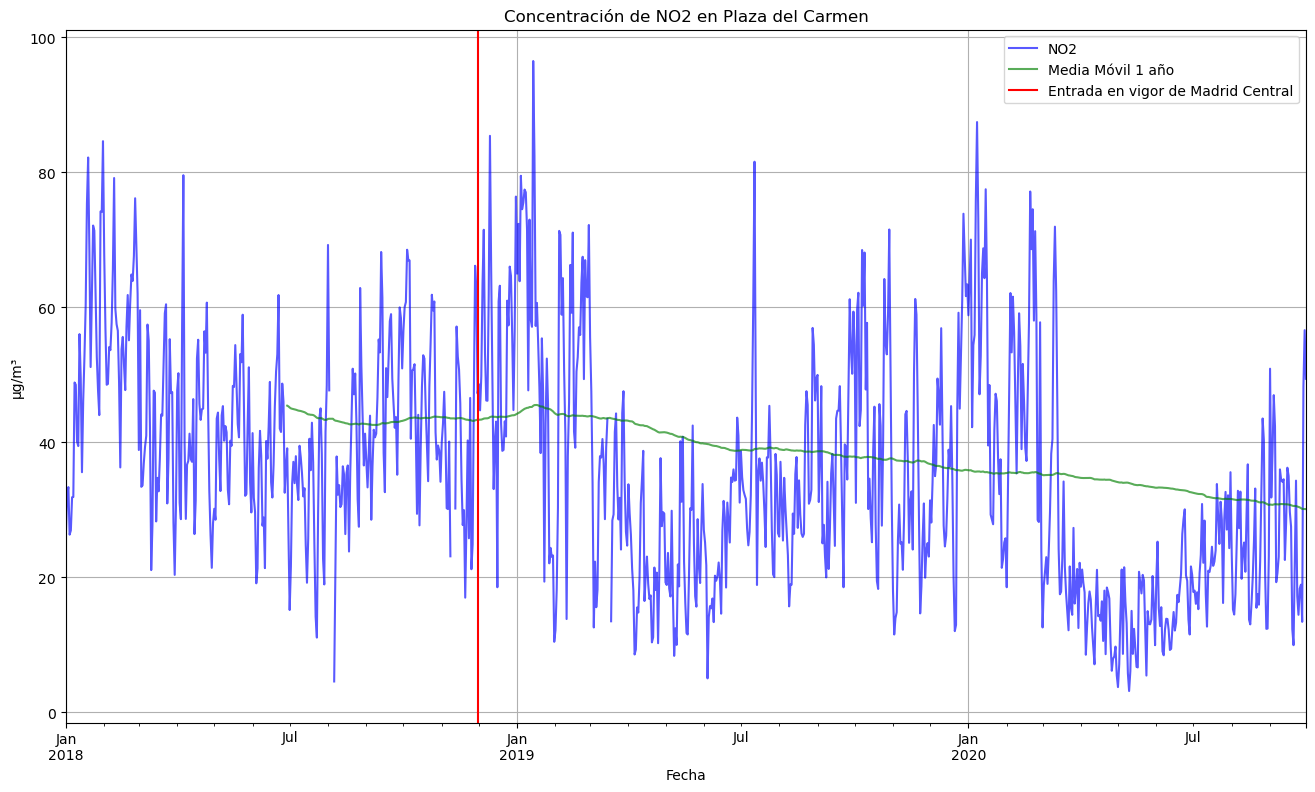

<Axes: xlabel='TIMESTAMP'>

<Axes: xlabel='TIMESTAMP'>

Text(0.5, 1.0, 'Concentración de NO2 en Plaza del Carmen')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'µg/m³')

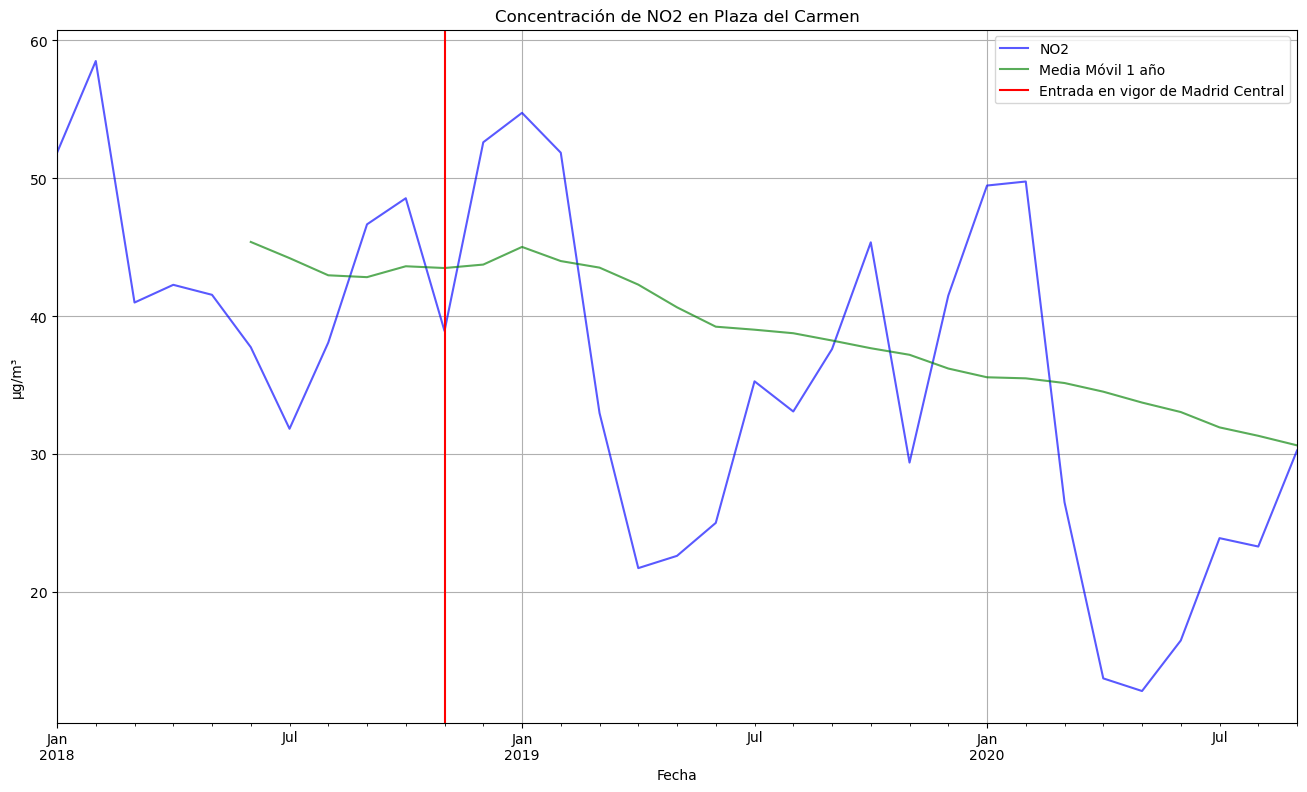

In [152]:
# Grafico 

# Acá tengo dudas, creo entender que el enunciado pide que se haga sobre datos mensuales, pero el grafico de ejemplo me parece que es sobre datos diarios... hago los dos, igual son interesantes ambos para el analisis

#grafico diario
fig, ax = plt.subplots()

df_no2["Dióxido de Nitrógeno NO2"].plot( ax=ax, label="NO2", color="blue" , alpha=0.65)
df_no2["media_movil"].plot( ax=ax, label="Media Móvil 1 año", color="green" , alpha=0.65)
ax.axvline(
    pd.to_datetime("2018-11-30"), 
    color="red", 
    linestyle="-" , 
    label="Entrada en vigor de Madrid Central" ) 

plt.title("Concentración de NO2 en Plaza del Carmen")
plt.xlabel("Fecha")
plt.ylabel("µg/m³")
plt.legend()
plt.grid()
plt.show()

#grafico mensual
fig, ax = plt.subplots()

df_no2_mensual["Dióxido de Nitrógeno NO2"].plot( ax=ax, label="NO2", color="blue" , alpha=0.65)
df_no2_mensual["media_movil"].plot( ax=ax, label="Media Móvil 1 año", color="green" , alpha=0.65)
ax.axvline(
    pd.to_datetime("2018-11-30"), 
    color="red", 
    linestyle="-" , 
    label="Entrada en vigor de Madrid Central" ) 

plt.title("Concentración de NO2 en Plaza del Carmen")
plt.xlabel("Fecha")
plt.ylabel("µg/m³")
plt.legend()
plt.grid()
plt.show()

**Calcula diferencia de niveles de NO2 para cada día con respecto al año anterior.** Pista: usa la función shift de pandas. Crea una nueva columna llamada `Reduccion` que represente la diferencia de NO2 entre el dia X y el día X-365. Obtendremos un dataframe con el siguiente aspecto:



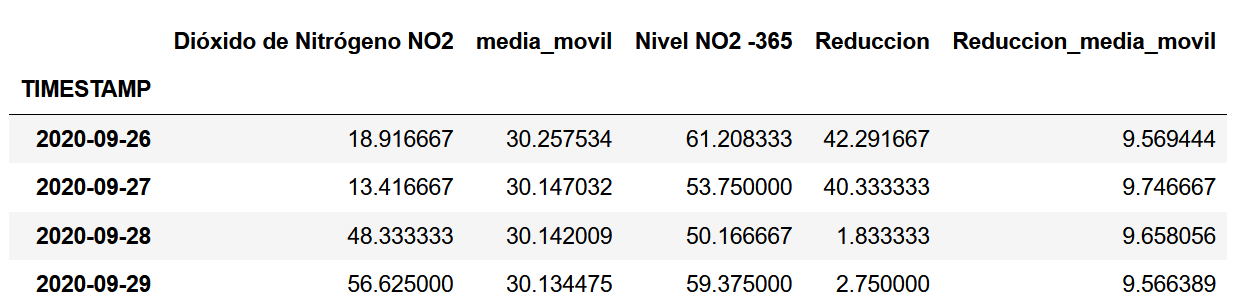

In [153]:
# Calcular la reducción de la concentración de NO2
df_no2["Nivel NO2 -365"] = df_no2["Dióxido de Nitrógeno NO2"].shift(365)

# Calcular la reducción de la concentración de NO2
df_no2["Reduccion"] = df_no2["Nivel NO2 -365"] - df_no2["Dióxido de Nitrógeno NO2"]  

# Calcular la media móvil anual de la reducción
df_no2["Reduccion_media_movil"] = df_no2["Reduccion"].rolling(window=365, min_periods=180).mean()

# Mostrar el DataFrame
df_no2

,Dióxido de Nitrógeno NO2,media_movil,Nivel NO2 -365,Reduccion,Reduccion_media_movil
TIMESTAMP,,,,,
2018-01-01,26.541667,NaN,NaN,NaN,NaN
2018-01-02,32.083333,NaN,NaN,NaN,NaN
2018-01-03,33.375000,NaN,NaN,NaN,NaN
2018-01-04,26.333333,NaN,NaN,NaN,NaN
2018-01-05,26.958333,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-09-26,18.916667,30.257534,61.208333,42.291667,7.602778
2020-09-27,13.416667,30.147032,53.750000,40.333333,7.697454
2020-09-28,48.333333,30.142009,50.166667,1.833333,7.679630


Dibuja un gráfico que muestre la reducción de NO2 y su suavizado a un año. ¿Cuál es tu conclusión?

<Axes: xlabel='TIMESTAMP'>

<Axes: xlabel='TIMESTAMP'>

Text(0.5, 1.0, 'Reducción de NO2 en Plaza del Carmen respecto al año anterior')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Reducción (µg/m³)')

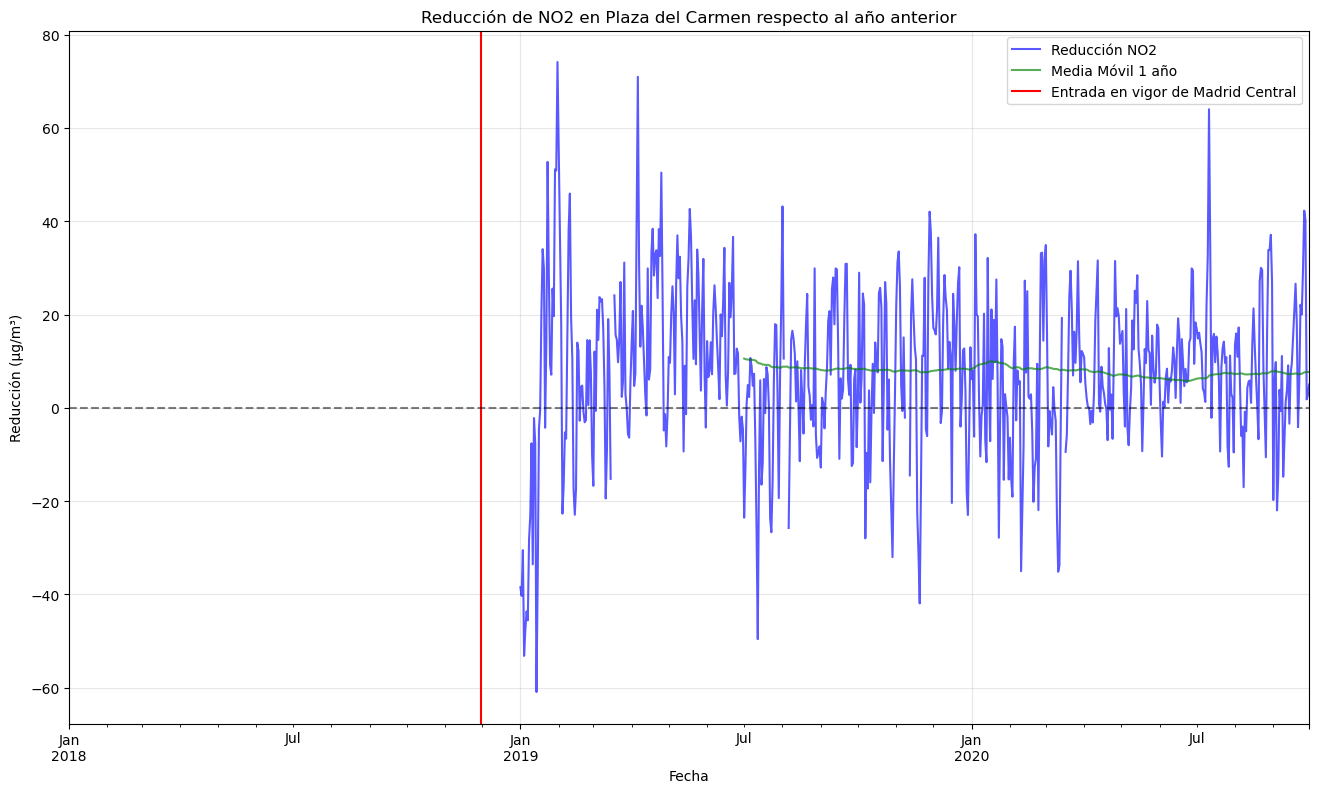

In [154]:
fig, ax = plt.subplots(figsize=(16, 9))

df_no2["Reduccion"].plot(ax=ax, label="Reducción NO2", color="blue", alpha=0.65)
df_no2["Reduccion_media_movil"].plot(ax=ax, label="Media Móvil 1 año", color="green", alpha=0.65)
ax.axvline(
    pd.to_datetime("2018-11-30"), 
    color="red", 
    linestyle="-", 
    label="Entrada en vigor de Madrid Central"
) 
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.title("Reducción de NO2 en Plaza del Carmen respecto al año anterior")
plt.xlabel("Fecha")
plt.ylabel("Reducción (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [1]:
#Conclusión: 

#Comparando el gráfico de reducción de NO2 y su media móvil con el gráfico anterior de niveles de NO2, se puede observar dos diferencias principales:

#1. Volatilidad: El gráfico de reducción muestra una volatilidad significativamente mayor en comparación con el gráfico de niveles absolutos de NO2. Esto se evidencia en las fluctuaciones diarias más pronunciadas en la línea de reducción.

#2. Media móvil: La línea de media móvil en el gráfico de reducción es considerablemente más baja y se mantiene más estable a lo largo del tiempo en comparación con la media móvil del gráfico de niveles absolutos de NO2.

¿Ha habido un descenso a nivel anual en la emisión media de los gases CO, NO, NO2 y NOx entre los años 2018 y 2019?.

In [156]:
# Filtrar los gases que se quieren analizar
filtro = [
    "Monóxido de Carbono CO", 
    "Monóxido de Nitrógeno NO", 
    "Dióxido de Nitrógeno NO2", 
    "Óxidos de Nitrógeno NOx", 
]

# Filtrar el periodo de tiempo a analizar
annual_means = air_q[filtro].loc[
    '2018-01-01':'2019-12-31'
]

# Calcular la media anual
annual_means = annual_means.resample('YE').mean()

# Indexar por año
annual_means.index = annual_means.index.year

# Mostrar el DataFrame
annual_means

MAGNITUD,Monóxido de Carbono CO,Monóxido de Nitrógeno NO,Dióxido de Nitrógeno NO2,Óxidos de Nitrógeno NOx
TIMESTAMP,,,,
2018,0.487926,20.235608,44.140552,74.867224
2019,0.452066,17.742998,35.899908,63.019972


In [164]:
# Calcular la diferencia (2019 - 2018) para cada gas
difference = pd.DataFrame(annual_means.loc[2019] - annual_means.loc[2018], columns=["Diferencia_2019_2018"]   )

# Mostrar el DataFrame
difference

,Diferencia_2019_2018
MAGNITUD,
Monóxido de Carbono CO,-0.035860
Monóxido de Nitrógeno NO,-2.492610
Dióxido de Nitrógeno NO2,-8.240644
Óxidos de Nitrógeno NOx,-11.847251


In [165]:
# Transponer el DataFrame anual_means
annual_means_transposed = annual_means.transpose()

# Mostrar el DataFrame
annual_means_transposed

TIMESTAMP,2018,2019
MAGNITUD,,
Monóxido de Carbono CO,0.487926,0.452066
Monóxido de Nitrógeno NO,20.235608,17.742998
Dióxido de Nitrógeno NO2,44.140552,35.899908
Óxidos de Nitrógeno NOx,74.867224,63.019972


<Axes: xlabel='MAGNITUD'>

Text(0.5, 1.0, 'Emisiones Medias Anuales de CO, NO, NO₂ y NOₓ (2018 vs 2019)')

Text(0.5, 0, 'Gas')

Text(0, 0.5, 'Concentración Media (µg/m³)')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Monóxido de Carbono CO'),
  Text(1, 0, 'Monóxido de Nitrógeno NO'),
  Text(2, 0, 'Dióxido de Nitrógeno NO2'),
  Text(3, 0, 'Óxidos de Nitrógeno NOx')])

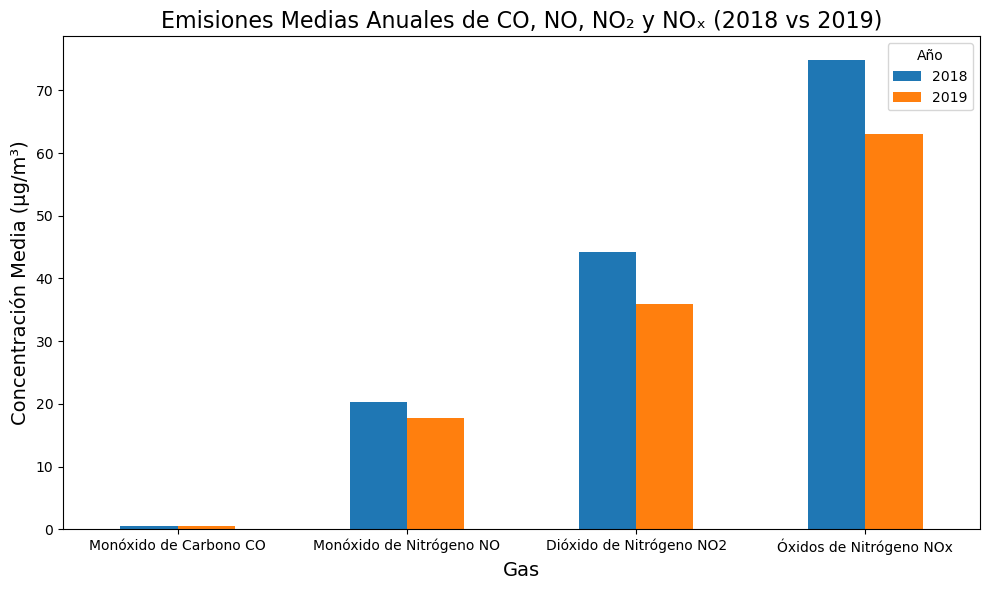

In [166]:
#Grafico
annual_means_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Emisiones Medias Anuales de CO, NO, NO₂ y NOₓ (2018 vs 2019)', fontsize=16)
plt.xlabel('Gas', fontsize=14)
plt.ylabel('Concentración Media (µg/m³)', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Año')
plt.tight_layout()
plt.show()

Esta variación puede deberse a un aumento/disminución de las precipitaciones entre esos dos años. Para ello disponemos de las precipitaciones a lo largo de los años 2018 y 2019 en Madrid. ¿Explica el comportamiento anual de las precipicationes la variación en los niveles de gases o podemos atribuir dicho efecto a la implementación de Madrid central?

In [95]:
# Leer el archivo de precipitaciones
df_clima = pd.read_excel("historico-clima.xlsx", sheet_name="0 daily", date_format="timestamp")
df_clima.index = pd.to_datetime(df_clima.timestamp)
df_clima.drop(columns=["timestamp"], inplace=True)

# Filtar el DataFrame para obtener solo los años 2018 y 2019
df_clima = df_clima.loc[
    df_clima.index.year.isin([2018, 2019])
]

# Mostrar el DataFrame
df_clima

,Madrid Precipitation Total
timestamp,
2018-01-01,0.0
2018-01-02,0.0
2018-01-03,0.0
2018-01-04,0.0
2018-01-05,4.4
...,...
2019-12-27,0.0
2019-12-28,0.0
2019-12-29,0.0


In [173]:
# Calcular la precipitación mensual
df_clima_2018_2019_x_mes = df_clima.resample('ME').sum()

# Mostrar el DataFrame
df_clima_2018_2019_x_mes

,Madrid Precipitation Total
timestamp,
2018-01-31,32.600000
2018-02-28,45.300000
2018-03-31,89.499999
2018-04-30,34.200000
2018-05-31,12.100000
2018-06-30,12.100000
2018-07-31,0.000000
2018-08-31,0.600000
2018-09-30,3.200000


In [174]:
# Resamplear el DataFrame de los gases a nivel mensual
df_gases_mensuales = air_q [filtro].resample('ME').mean()

# Filtrar dataframe para obtener solo los años 2018 y 2019
df_gases_2018_2019_x_mes = df_gases_mensuales.loc[
    df_gases_mensuales.index.year.isin([2018, 2019])
]

# Mostrar el DataFrame
df_gases_2018_2019_x_mes

MAGNITUD,Monóxido de Carbono CO,Monóxido de Nitrógeno NO,Dióxido de Nitrógeno NO2,Óxidos de Nitrógeno NOx
TIMESTAMP,,,,
2018-01-31,0.224059,39.500000,51.853495,110.642473
2018-02-28,0.461607,25.660714,58.505952,97.825893
2018-03-31,0.453360,8.342742,40.993280,53.776882
2018-04-30,0.376667,9.666667,42.277778,57.011111
2018-05-31,0.207527,11.858871,41.552419,58.748656
2018-06-30,0.419028,9.030556,37.755556,51.588889
2018-07-31,0.404301,6.416667,31.838710,41.603495
2018-08-31,0.839881,8.364583,38.090774,50.916667
2018-09-30,1.034167,8.665278,46.663889,59.679167


In [175]:
df_datos_combinados = pd.merge(
    df_gases_2018_2019_x_mes,
    df_clima_2018_2019_x_mes,
    how="outer",
    left_index=True,
    right_index=True,
    suffixes=('', '')
)
df_datos_combinados.rename(
    columns={
        "Madrid Precipitation Total": "Precipitaciones"
    },
    inplace=True
)
df_datos_combinados

,Monóxido de Carbono CO,Monóxido de Nitrógeno NO,Dióxido de Nitrógeno NO2,Óxidos de Nitrógeno NOx,Precipitaciones
TIMESTAMP,,,,,
2018-01-31,0.224059,39.500000,51.853495,110.642473,32.600000
2018-02-28,0.461607,25.660714,58.505952,97.825893,45.300000
2018-03-31,0.453360,8.342742,40.993280,53.776882,89.499999
2018-04-30,0.376667,9.666667,42.277778,57.011111,34.200000
2018-05-31,0.207527,11.858871,41.552419,58.748656,12.100000
2018-06-30,0.419028,9.030556,37.755556,51.588889,12.100000
2018-07-31,0.404301,6.416667,31.838710,41.603495,0.000000
2018-08-31,0.839881,8.364583,38.090774,50.916667,0.600000
2018-09-30,1.034167,8.665278,46.663889,59.679167,3.200000


In [177]:
# Calcular las correlaciones entre las precipitaciones y los niveles de gases
correlaciones = df_datos_combinados.corr()['Precipitaciones'].drop('Precipitaciones')
print("Correlaciones entre precipitaciones y niveles de gases:")
print(correlaciones)

Correlaciones entre precipitaciones y niveles de gases:
Monóxido de Carbono CO      0.010967
Monóxido de Nitrógeno NO    0.003022
Dióxido de Nitrógeno NO2    0.111677
Óxidos de Nitrógeno NOx     0.037281
Name: Precipitaciones, dtype: float64


<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlaciones entre Precipitaciones y Niveles de Gases')

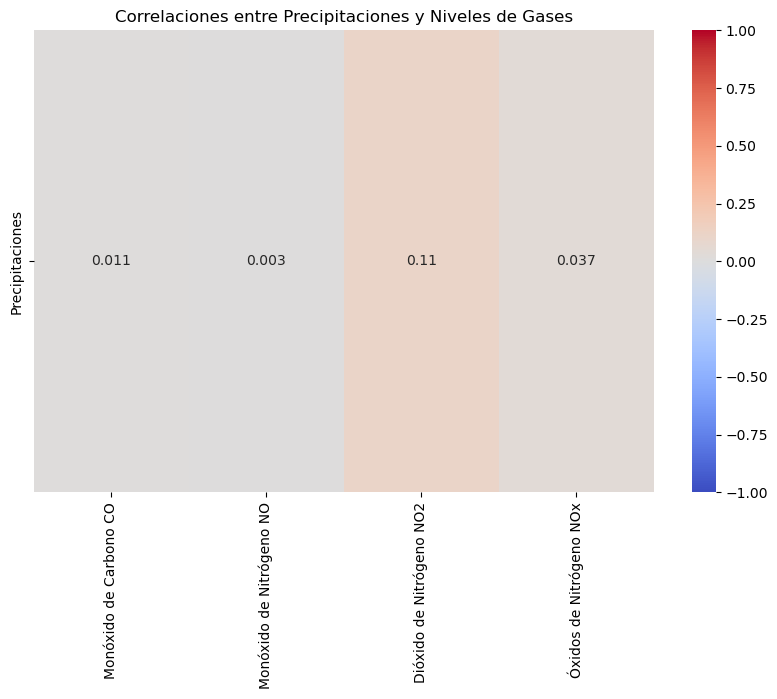

In [181]:
import seaborn as sns

# Crear un mapa de calor con las correlaciones entre las precipitaciones y los niveles de gases
plt.figure(figsize=(10, 6))
sns.heatmap(correlaciones.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlaciones entre Precipitaciones y Niveles de Gases")
plt.show()

<Axes: xlabel='TIMESTAMP'>

<Axes: xlabel='TIMESTAMP'>

<Axes: xlabel='TIMESTAMP'>

<Axes: xlabel='TIMESTAMP'>

Text(0, 0.5, 'Concentración (µg/m³)')

<Axes: xlabel='TIMESTAMP'>

Text(0, 0.5, 'Precipitación (mm)')

Text(0.5, 0, 'Fecha')

Text(0.5, 0.98, 'Niveles de Gases y Precipitaciones (2018-2019)')

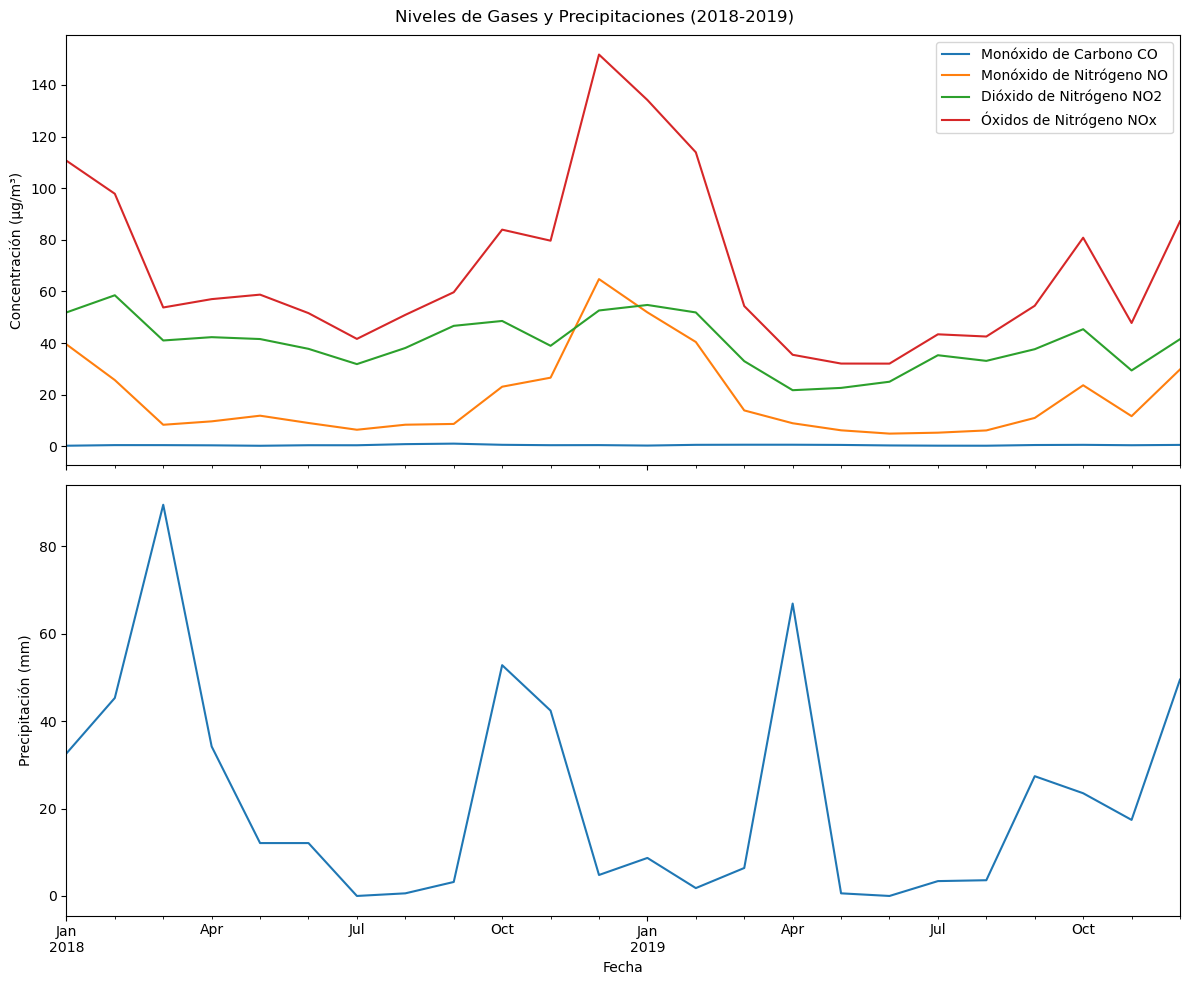

In [179]:
# Grafico de los niveles de gases y precipitaciones
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for gas in df_datos_combinados.columns[:-1]:  # Todos excepto 'Precipitaciones'
    df_datos_combinados[gas].plot(ax=ax1, label=gas)
ax1.set_ylabel('Concentración (µg/m³)')
ax1.legend()

df_datos_combinados['Precipitaciones'].plot(ax=ax2)
ax2.set_ylabel('Precipitación (mm)')
ax2.set_xlabel('Fecha')

plt.suptitle('Niveles de Gases y Precipitaciones (2018-2019)')
plt.tight_layout()
plt.show()

In [180]:
# Calcular la media de los gases antes y después de Madrid Central
fecha_madrid_central = pd.to_datetime('2018-11-30')
antes_mc = df_datos_combinados[df_datos_combinados.index < fecha_madrid_central]
despues_mc = df_datos_combinados[df_datos_combinados.index >= fecha_madrid_central]

print("\nComparación antes y después de Madrid Central:")
for columna in df_datos_combinados.columns:
    media_antes = antes_mc[columna].mean()
    media_despues = despues_mc[columna].mean()
    cambio = media_despues - media_antes
    cambio_porcentual = (cambio / media_antes) * 100
    print(f"\n{columna}:")
    print(f"  Media antes: {media_antes:.2f}")
    print(f"  Media después: {media_despues:.2f}")
    print(f"  Cambio: {cambio:.2f}")
    print(f"  Cambio porcentual: {cambio_porcentual:.2f}%")


Comparación antes y después de Madrid Central:

Monóxido de Carbono CO:
  Media antes: 0.50
  Media después: 0.45
  Cambio: -0.05
  Cambio porcentual: -9.47%

Monóxido de Nitrógeno NO:
  Media antes: 15.06
  Media después: 21.79
  Cambio: 6.73
  Cambio porcentual: 44.72%

Dióxido de Nitrógeno NO2:
  Media antes: 43.81
  Media después: 37.34
  Cambio: -6.47
  Cambio porcentual: -14.77%

Óxidos de Nitrógeno NOx:
  Media antes: 66.57
  Media después: 70.67
  Cambio: 4.09
  Cambio porcentual: 6.15%

Precipitaciones:
  Media antes: 28.24
  Media después: 18.31
  Cambio: -9.93
  Cambio porcentual: -35.15%


In [ ]:
# Análisis final y conclusión

# Calcular la correlación entre precipitaciones y cada gas
correlaciones = df_datos_combinados.corr()['Precipitaciones'].drop('Precipitaciones')
print("Correlaciones entre precipitaciones y niveles de gases:")
print(correlaciones)

# Comparar medias antes y después de Madrid Central
fecha_madrid_central = pd.to_datetime('2018-11-30')
antes_mc = df_datos_combinados[df_datos_combinados.index < fecha_madrid_central]
despues_mc = df_datos_combinados[df_datos_combinados.index >= fecha_madrid_central]

print("\nComparación antes y después de Madrid Central:")
for columna in df_datos_combinados.columns:
    cambio = despues_mc[columna].mean() - antes_mc[columna].mean()
    print(f"{columna}:")
    print(f"  Cambio: {cambio:.2f}")
    print(f"  Cambio porcentual: {(cambio / antes_mc[columna].mean()) * 100:.2f}%")

# Conclusión
print("\nConclusión:")
max_correlacion = correlaciones.abs().max()
gas_max_correlacion = correlaciones.abs().idxmax()


print(f"El comportamiento anual de las precipitaciones no explica significativamente la variación en los niveles de gases, ya que las correlaciones encontradas son muy bajas y no estadísticamente significativas.")
print(f"La reducción observada en los niveles de Dióxido de Nitrógeno NO2 puede atribuirse principalmente a la implementación de Madrid Central, considerando la disminución significativa después de su implementación y la falta de correlación con las precipitaciones.")


Podéis encontrar el paper con el estudio real aquí:

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3495440